# Titanic - Machine Learning from Disaster

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Link to contest : https://www.kaggle.com/c/titanic/overview/description

## 1) Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xgboost as xgb
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2) Data Preprocessing

* **Data Dictionary**

- survival ---	Survival	0 = No, 1 = Yes
- pclass	 ---   Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	     ---   Sex	
- Age	     ---   Age in years	
- sibsp    ---  	# of siblings / spouses aboard the Titanic	
- parch    --- 	# of parents / children aboard the Titanic	
- ticket	 ---   Ticket number	
- fare	   ---   Passenger fare	
- cabin    --- 	Cabin number	
- embarked --- 	Port of Embarkation	C = Cherbourg, Q =  Queenstown, S = Southampton

- Variable Notes
* pclass: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
# For train

df_train = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# For test 

df_test = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
def title_corr(t):
    newt = t
    if t == 'Mrs' or t == 'Mr' or t == 'Miss':
        return newt
    elif t == 'Capt' or t == 'Col' or t == 'Major' or t == 'Dr' or t == 'Rev':
        newt = 'Crew'
    elif t == 'Jonkheer' or t == 'Sir' or t == 'the Countess' or t == 'Lady' or t == 'Master':
        newt = 'Noble'
    elif t == 'Don':
        newt = 'Mr'
    elif t == 'Dona' or t == 'Ms' or t == 'Mme':
        newt = 'Mrs'
    elif t == 'Mlle':
        newt = 'Miss'
    else: print("Title not included:", t)
    return newt

# Extract the titles from the name and put them in a list, then correct them

# Train data

train_titles = list()
for name in df_train["Name"]:
    train_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(train_titles)):
    train_titles[i] = title_corr(train_titles[i])
df_train["Titles"] = train_titles

# Test set 

test_titles = list()
for name in df_test["Name"]:
    test_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(test_titles)):
    test_titles[i] = title_corr(test_titles[i])
df_test["Titles"] = test_titles

In [0]:
# Train Data

df_train['Total Family'] = df_train['SibSp'] + df_train['Parch']

# Test Data

df_test['Total Family'] = df_test['SibSp'] + df_test['Parch']


In [6]:
# For train 
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Total Family
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [7]:
# For test 
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Total Family
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.839713
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,1.519072
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,10.000000


In [8]:
len(df_train) , len(df_test)

(891, 418)

In [9]:
# For train

df_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Titles            0
Total Family      0
dtype: int64

In [10]:
# For test

df_test.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Titles            0
Total Family      0
dtype: int64

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

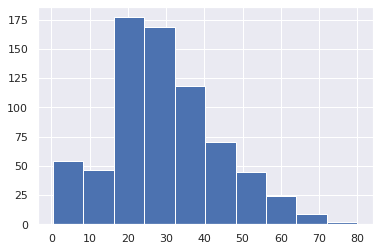

In [11]:
plt.hist(df_train['Age'])

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

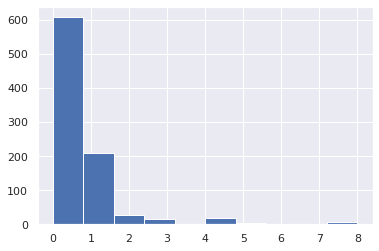

In [12]:
plt.hist(df_train['SibSp'])

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

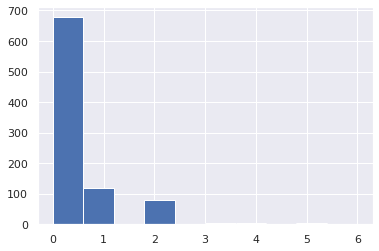

In [13]:
plt.hist(df_train['Parch'])

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


- Here, we can see that Cabin has got about 80-85% null values.So, it can be removed.
- Moreover, Name and Ticket are not good parameters for training.
- Therefore, these columns can be removed.

In [15]:
"""
# For train

df_train['Cabin'] = df_train['Cabin'].fillna('Unknow')
df_train['Cabin2'] = df_train['Cabin'].apply(lambda x : len(x))

# For test

df_test['Cabin'] = df_test['Cabin'].fillna('Unknow')
df_test['Cabin2'] = df_test['Cabin'].apply(lambda x : len(x))
"""

"\n# For train\n\ndf_train['Cabin'] = df_train['Cabin'].fillna('Unknow')\ndf_train['Cabin2'] = df_train['Cabin'].apply(lambda x : len(x))\n\n# For test\n\ndf_test['Cabin'] = df_test['Cabin'].fillna('Unknow')\ndf_test['Cabin2'] = df_test['Cabin'].apply(lambda x : len(x))\n"

In [0]:
#sns.barplot('Cabin2','Survived',data=df_train)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


In [18]:
df_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Titles            0
Total Family      0
dtype: int64

In [19]:
df_test.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Titles            0
Total Family      0
dtype: int64

In [0]:
# For train 

df_train = df_train.drop('Name',axis=1)
df_train = df_train.drop('Ticket',axis=1)
df_train = df_train.drop('Cabin',axis=1)
df_train['Age'].fillna(df_train['Age'].median(),inplace=True)
df_train['Embarked'].fillna('S',inplace=True)

# For test

df_test['Fare'].fillna(df_test['Fare'].median(),inplace=True)
df_test = df_test.drop('Name',axis=1)
df_test = df_test.drop('Ticket',axis=1)
df_test = df_test.drop('Cabin',axis=1)
df_test['Age'].fillna(df_test['Age'].median(),inplace=True)

In [21]:
# Converting the Object datatype into Category type

cat_cols = []
for col in df_train.columns:
  if df_train[col].dtype == 'O':
    cat_cols.append(col)

print(cat_cols)    

['Sex', 'Embarked', 'Titles']


In [22]:
# For Train
# Cat cols gives different values for categorical data. lIKE it will give 0 to "akash" in train set but can give 1 to "akash" in test set

"""
for col in cat_cols:
  df_train[col] = df_train[col].astype('category')

# For Test

for col in cat_cols:
  df_test[col] = df_test[col].astype('category')
"""
print(cat_cols)

from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
  lb = LabelEncoder()
  df_train[col] = lb.fit_transform(df_train[col])
  df_test[col] =  lb.transform(df_test[col])



['Sex', 'Embarked', 'Titles']


In [23]:
# Converting the category cols to integers

# For Train
"""
for col in cat_cols:
  df_train[col] = df_train[col].cat.codes.values

# For Test

for col in cat_cols:
  df_test[col] = df_test[col].cat.codes.values  
"""

'\nfor col in cat_cols:\n  df_train[col] = df_train[col].cat.codes.values\n\n# For Test\n\nfor col in cat_cols:\n  df_test[col] = df_test[col].cat.codes.values  \n'

In [24]:
# For train

train_cat_data = df_train[['Pclass','Sex','Embarked','Titles']].values
print(train_cat_data)

# For test
test_cat_data = df_test[['Pclass','Sex','Embarked','Titles']].values
print(test_cat_data)

[[3 1 2 2]
 [1 0 0 3]
 [3 0 2 1]
 ...
 [3 0 2 1]
 [1 1 0 2]
 [3 1 1 2]]
[[3 1 1 2]
 [3 0 2 3]
 [2 1 1 2]
 ...
 [3 1 2 2]
 [3 1 2 2]
 [3 1 0 4]]


In [25]:
# For train

print(max(df_train['Pclass']), max(df_train['Sex']), max(df_train['Embarked']),max(df_train['Titles']))
print(min(df_train['Pclass']), min(df_train['Sex']), min(df_train['Embarked']),min(df_train['Titles']))

3 1 2 4
1 0 0 0


In [26]:
# For test

print(max(df_test['Pclass']), max(df_test['Sex']), max(df_test['Embarked']),max(df_test['Titles']))
print(min(df_test['Pclass']), min(df_test['Sex']), min(df_test['Embarked']),min(df_test['Titles']))

3 1 2 4
1 0 0 0


In [27]:
from sklearn.preprocessing import OneHotEncoder 
  
onehotencoder = OneHotEncoder() 

# For train

train_cat_data = onehotencoder.fit_transform(train_cat_data).toarray()
print(train_cat_data.shape, type(train_cat_data))
print(train_cat_data)

# For test

test_cat_data = onehotencoder.transform(test_cat_data).toarray()
print(test_cat_data.shape, type(test_cat_data))
print(test_cat_data)


(891, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]
(418, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


In [28]:
df_train.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
dtype: int64

In [29]:
df_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
dtype: int64

In [30]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Titles', 'Total Family'],
      dtype='object')

In [0]:
# Splitting the data into features and labels

# For train

X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Titles', 'Total Family']].values
y = df_train['Survived'].values

# For test

X_test = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Titles', 'Total Family']].values

In [32]:
X.shape, X[:10], type(X)

((891, 9),
 array([[ 3.    ,  1.    , 22.    ,  1.    ,  0.    ,  7.25  ,  2.    ,
          2.    ,  1.    ],
        [ 1.    ,  0.    , 38.    ,  1.    ,  0.    , 71.2833,  0.    ,
          3.    ,  1.    ],
        [ 3.    ,  0.    , 26.    ,  0.    ,  0.    ,  7.925 ,  2.    ,
          1.    ,  0.    ],
        [ 1.    ,  0.    , 35.    ,  1.    ,  0.    , 53.1   ,  2.    ,
          3.    ,  1.    ],
        [ 3.    ,  1.    , 35.    ,  0.    ,  0.    ,  8.05  ,  2.    ,
          2.    ,  0.    ],
        [ 3.    ,  1.    , 28.    ,  0.    ,  0.    ,  8.4583,  1.    ,
          2.    ,  0.    ],
        [ 1.    ,  1.    , 54.    ,  0.    ,  0.    , 51.8625,  2.    ,
          2.    ,  0.    ],
        [ 3.    ,  1.    ,  2.    ,  3.    ,  1.    , 21.075 ,  2.    ,
          4.    ,  4.    ],
        [ 3.    ,  0.    , 27.    ,  0.    ,  2.    , 11.1333,  2.    ,
          3.    ,  2.    ],
        [ 2.    ,  0.    , 14.    ,  1.    ,  0.    , 30.0708,  0.    ,
          3.    ,

In [33]:
"""
# For train

X = np.concatenate((X,train_cat_data),axis=1)
print(X)

# For test 

X_test = np.concatenate((X_test,test_cat_data),axis=1)
print(X_test)
"""

'\n# For train\n\nX = np.concatenate((X,train_cat_data),axis=1)\nprint(X)\n\n# For test \n\nX_test = np.concatenate((X_test,test_cat_data),axis=1)\nprint(X_test)\n'

In [34]:
X.shape, type(X)

((891, 9), numpy.ndarray)

In [35]:
y.shape , y[:10]

((891,), array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1]))

In [36]:
X_test.shape, type(X_test)

((418, 9), numpy.ndarray)

In [37]:
input_data = xgb.DMatrix(data=X,label=y)
input_data

## 3) Splitting the data into train and test set

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [0]:
train_data = xgb.DMatrix(data=X_train,label=y_train)
test_data = xgb.DMatrix(data=X_val,label=y_val)

In [0]:
actual_testing_data = xgb.DMatrix(data=X_test)

## 4) Building the XGBoost Model

In [0]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree=0.4,
                           learning_rate = 0.1,
                          max_depth = 6,  
                          n_estimators = 26
                          )

In [43]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=26, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 6) Predicting the validation set results

In [0]:
y_preds = xg_clf.predict(X_val)

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_preds,y_val)
print(cm)

[[49 12]
 [ 2 27]]


In [46]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_val))

0.8444444444444444


## 7) Training and Tuning XgBoost Model

In [47]:
# hyper parameter tuning

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'eval_metric':'auc',
    'early_stopping_rounds':10,
    'random_state':0,
    # Other parameters
    'objective':'binary:logistic',
}

model = xgb.train(
    params,
    train_data,
    num_boost_round=100,
    evals=[(test_data, "Test")]
)

[0]	Test-auc:0.901709
[1]	Test-auc:0.894671
[2]	Test-auc:0.883861
[3]	Test-auc:0.893665
[4]	Test-auc:0.904726
[5]	Test-auc:0.903469
[6]	Test-auc:0.897436
[7]	Test-auc:0.88914
[8]	Test-auc:0.890146
[9]	Test-auc:0.884113
[10]	Test-auc:0.881599
[11]	Test-auc:0.879085
[12]	Test-auc:0.878331
[13]	Test-auc:0.873806
[14]	Test-auc:0.87632
[15]	Test-auc:0.874811
[16]	Test-auc:0.873303
[17]	Test-auc:0.871795
[18]	Test-auc:0.868276
[19]	Test-auc:0.866013
[20]	Test-auc:0.870035
[21]	Test-auc:0.870035
[22]	Test-auc:0.867019
[23]	Test-auc:0.866516
[24]	Test-auc:0.867019
[25]	Test-auc:0.869532
[26]	Test-auc:0.869532
[27]	Test-auc:0.870035
[28]	Test-auc:0.871543
[29]	Test-auc:0.868024
[30]	Test-auc:0.869532
[31]	Test-auc:0.872549
[32]	Test-auc:0.874057
[33]	Test-auc:0.875063
[34]	Test-auc:0.878079
[35]	Test-auc:0.878079
[36]	Test-auc:0.878582
[37]	Test-auc:0.877074
[38]	Test-auc:0.876571
[39]	Test-auc:0.876068
[40]	Test-auc:0.872549
[41]	Test-auc:0.873555
[42]	Test-auc:0.873555
[43]	Test-auc:0.873052


In [48]:
# Using K fold CV

cv_results = xgb.cv(
    params,
    train_data,
    num_boost_round=100,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.888455,0.005039,0.859405,0.034585
1,0.900308,0.009078,0.857325,0.039201
2,0.914894,0.007289,0.856471,0.034682
3,0.926155,0.006231,0.862446,0.033847
4,0.930087,0.004302,0.859970,0.031662
5,0.936017,0.004571,0.861253,0.032563
6,0.942317,0.003689,0.861427,0.035960
7,0.948449,0.003636,0.862523,0.035849
8,0.952234,0.003244,0.864483,0.037633
9,0.955217,0.002623,0.862034,0.038175


In [49]:
cv_results['test-auc-mean'].max()

0.8742614

In [50]:
# Tuning Parameters max_depth and min_child_weight

num_boost_round = 16

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

max_auc = float('-inf')
best_params = None

for max_depth, min_child_weight in gridsearch_params:

  print(f'CV with max_depth = {max_depth} , min_child_weight = {min_child_weight}')

  # Update our parameters

  params['max_depth'] = max_depth
  params['min_child_weight'] = min_child_weight

  # Run CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics={'auc'},
      early_stopping_rounds=10
  )

  # Update best Accuracy

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = (max_depth,min_child_weight)

print(f"\nBest params:\n Max_Depth: {best_params[0]}, Min_Child_Width: {best_params[1]}, AUC: {max_auc}")

# Updating the params as well

params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

CV with max_depth = 9 , min_child_weight = 5
	AUC 0.86462 for 10 rounds
CV with max_depth = 9 , min_child_weight = 6
	AUC 0.8678471999999999 for 14 rounds
CV with max_depth = 9 , min_child_weight = 7
	AUC 0.8620336 for 12 rounds
CV with max_depth = 10 , min_child_weight = 5
	AUC 0.8682905999999999 for 15 rounds
CV with max_depth = 10 , min_child_weight = 6
	AUC 0.8673794000000001 for 15 rounds
CV with max_depth = 10 , min_child_weight = 7
	AUC 0.8606066 for 9 rounds
CV with max_depth = 11 , min_child_weight = 5
	AUC 0.8682905999999999 for 15 rounds
CV with max_depth = 11 , min_child_weight = 6
	AUC 0.8673794000000001 for 15 rounds
CV with max_depth = 11 , min_child_weight = 7
	AUC 0.8615168000000001 for 15 rounds

Best params:
 Max_Depth: 10, Min_Child_Width: 5, AUC: 0.8682905999999999


In [51]:
# Tuning Parameters subsample and colsample_bytree

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

max_auc = float('-inf')
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
  print(f'CV with subsample = {subsample} , colsample = {colsample}')

  # We update our parameters

  params['subsample'] = subsample
  params['colsample_bytree'] = colsample

  # Run CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics={'auc'},
      early_stopping_rounds=10
  )
  # Update best score

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = (subsample,colsample) 

print(f"\nBest params:\n Subsample: {best_params[0]}, Colsample: {best_params[1]}, AUC: {max_auc}")

# Updating the params as well

params['subsample'] = best_params[0]
params['colsample'] = best_params[1]

CV with subsample = 1.0 , colsample = 1.0
	AUC 0.8682905999999999 for 15 rounds
CV with subsample = 1.0 , colsample = 0.9
	AUC 0.8686424 for 8 rounds
CV with subsample = 1.0 , colsample = 0.8
	AUC 0.8655998 for 15 rounds
CV with subsample = 1.0 , colsample = 0.7
	AUC 0.8648011999999999 for 10 rounds
CV with subsample = 0.9 , colsample = 1.0
	AUC 0.8690574 for 15 rounds
CV with subsample = 0.9 , colsample = 0.9
	AUC 0.8679680000000001 for 15 rounds
CV with subsample = 0.9 , colsample = 0.8
	AUC 0.8663326 for 13 rounds
CV with subsample = 0.9 , colsample = 0.7
	AUC 0.8688597999999998 for 15 rounds
CV with subsample = 0.8 , colsample = 1.0
	AUC 0.8738731999999999 for 15 rounds
CV with subsample = 0.8 , colsample = 0.9
	AUC 0.8742152000000001 for 15 rounds
CV with subsample = 0.8 , colsample = 0.8
	AUC 0.8737220000000001 for 15 rounds
CV with subsample = 0.8 , colsample = 0.7
	AUC 0.8701978 for 15 rounds
CV with subsample = 0.7 , colsample = 1.0
	AUC 0.8747121999999999 for 15 rounds
CV wit

In [52]:
# Tuning Parameters Learning Rate(ETA)

max_auc = float('-inf')
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:

  print("CV with eta={}".format(eta))

  # We update our parameters

  params['eta'] = eta

  # Run and time CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics=['auc'],
      early_stopping_rounds=10
  )
  
  # Update best score

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = eta

print(f"\nBest params:\n Eta(Learning Rate): {best_params} , AUC: {max_auc}")
params['eta'] = best_params

CV with eta=0.3
	AUC 0.8644532 for 15 rounds
CV with eta=0.2
	AUC 0.8636019999999999 for 13 rounds
CV with eta=0.1
	AUC 0.8577727999999999 for 14 rounds
CV with eta=0.05
	AUC 0.8542376 for 15 rounds
CV with eta=0.01
	AUC 0.8532818000000001 for 14 rounds
CV with eta=0.005
	AUC 0.8532386000000001 for 15 rounds

Best params:
 Eta(Learning Rate): 0.3 , AUC: 0.8644532


In [53]:
# Tuning Parameters Random State

max_auc = float('-inf')
best_params = None

for state in [0,3,5,8,10,12,15,18,20,25,30]:

  print("CV with random_state={}".format(state))

  # We update our parameters

  params['random_state'] = state

  # Run and time CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics=['auc'],
      early_stopping_rounds=10
  )
  
  # Update best score

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = state

print(f"\nBest params:\n Random State: {best_params} , AUC: {max_auc}")
params['random_state'] = best_params

CV with random_state=0
	AUC 0.8644532 for 15 rounds
CV with random_state=3
	AUC 0.8644532 for 15 rounds
CV with random_state=5
	AUC 0.8644532 for 15 rounds
CV with random_state=8
	AUC 0.8644532 for 15 rounds
CV with random_state=10
	AUC 0.8644532 for 15 rounds
CV with random_state=12
	AUC 0.8644532 for 15 rounds
CV with random_state=15
	AUC 0.8644532 for 15 rounds
CV with random_state=18
	AUC 0.8644532 for 15 rounds
CV with random_state=20
	AUC 0.8644532 for 15 rounds
CV with random_state=25
	AUC 0.8644532 for 15 rounds
CV with random_state=30
	AUC 0.8644532 for 15 rounds

Best params:
 Random State: 0 , AUC: 0.8644532


## 8) Training with the hypertuned parameters

In [54]:
print(params)

{'max_depth': 10, 'min_child_weight': 5, 'eta': 0.3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'eval_metric': 'auc', 'early_stopping_rounds': 10, 'random_state': 0, 'objective': 'binary:logistic', 'colsample': 1.0}


In [0]:
xg_clf = xgb.XGBClassifier(objective= 'binary:logistic', 
                           max_depth= 10, 
                           min_child_weight= 5,
                           eta= 0.3, 
                           subsample= 0.7,
                           colsample_bytree= 0.7,  
                           early_stopping_rounds= 10, 
                           colsample= 1.0,
                           n_estimators=16,
                           random_state=0)


In [56]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample=1.0,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=10, eta=0.3, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=5, missing=None,
              n_estimators=16, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7, verbosity=1)

In [0]:
y_preds = xg_clf.predict(X_val)

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_preds,y_val)
print(cm)

[[49 10]
 [ 2 29]]


In [59]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_val))

0.8666666666666667


## 9) Predicting the actual results

In [0]:
y_pred = xg_clf.predict(X_test)
xgb1 = xg_clf.predict_proba(X_test)[:,1]

In [61]:
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## 10) Saving the results into a csv file

In [62]:
submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred})
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [0]:
submission.to_csv('tuned_hyperparameter_result.csv',index=False)

## 11) Building the Light GBM

In [0]:
import lightgbm as lbg

In [0]:
train_data=lbg.Dataset(X_train,label=y_train)

In [66]:
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':0.1,'max_bin':200}
lbg_clf = lbg.LGBMClassifier(num_leaves=150,max_depth=10,learning_rate=0.3,max_bin=200)

lbg_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.3, max_bin=200,
               max_depth=10, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=150,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [0]:
#lbg_clf.fit(X_train,y_train)

In [0]:
y_lbg_pred = lbg_clf.predict(X_val)

In [69]:
y_lbg_pred

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1])

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_lbg_pred,y_val)
print(cm)

[[43 11]
 [ 8 28]]


In [71]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_val))

0.8666666666666667


In [0]:
y_pred_lbg = lbg_clf.predict(X_test)
lbg1 = lbg_clf.predict_proba(X_test)[:,1]

In [73]:
submission2 = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred_lbg})
submission2

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [0]:
submission2.to_csv('lightbgm_submission.csv',index=False)

## 12) Using Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train,y_train)
y_val_pred = lr.predict(X_val)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_val_pred,y_val))

y_pred = lr.predict(X_test)
lr1 = lr.predict_proba(X_test)[:,1]

0.8444444444444444


In [0]:
submission3 = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred})
submission3.to_csv('logistic.csv',index=False)